In [350]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
from __future__ import division
import sys,os,time
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
#import pygmt
import csv
import pandas as pd
import bp_lib
from joblib import Parallel, delayed
import obspy.geodetics
from obspy.signal.cross_correlation import xcorr_pick_correction # for cross-correlation


num_cores = 12
root_order = 2
corr_window=10
snr_window=10
extra_label='_10_sps'

file='input_default.csv'
file='input_Myanmar_March_2025_AU.csv'

input = pd.read_csv('./'+file,header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])

##########################################################################
# Event info

Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])

Array_name=res['Array_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
try:
    backazimuth_min=float(res['backazimuth_min'])
    backazimuth_max=float(res['backazimuth_max'])
except:
    pass
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)

Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                  , magnitude=float(res['event_magnitude']))
stations = str(res['stations'])
waveforms= str(res['waveforms']) 
##########################################################################
# BP parameters
##########################################################################
model               = TauPyModel(model=str(res['model']))
Start_P_cut_time    = float(res['Start_P_cut_time'])  #before P arrival in seconds
End_P_cut_time      = float(res['End_P_cut_time']) #After P arrival seconds
sps                 = float(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
bp_l                = float(res['bp_l']) #Hz
bp_u                = float(res['bp_u'])   #Hz
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
#smooth_time_window  = int((STF_end-STF_start)/10) #int(res['smooth_time_window'])   #seconds
smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window  = int(res['smooth_space_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend  = float(res['source_grid_extend'])   #degrees
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
path = os.getcwd()
#Exp_name=res['Exp_name']
Exp_name=str(Array_name)+'_'+str(event_depth)+'km_'+str(res['model'])+'_'+str(source_grid_size)+'_grid'+str(extra_label)
#outdir = str(Event)+'_'+str(Exp_name)
#print('Working in Exp:',outdir)
#isExist = os.path.exists(outdir)
#if not isExist:
#        print('\n###########################################')
#        print('Output directory does not exist. Making one for you.')
#        print('\n###########################################')
#        os.makedirs(outdir)
#else:
#        print('\n###########################################') 
#        print('Output directory exists. It will be overwritted.')
#        print('\n###########################################')

##########################################################################
# saving the input file 
#with open(outdir+'/'+'input.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    for row in res.items():
#        writer.writerow(row)
###########################################################################
#Array_name           = 'AU'
#inv                  = obspy.read_inventory(stations)
stream_orig          = obspy.read(waveforms)
stream_work          = stream_orig.copy()
##########################################################################
# Making potential sources grid
##########################################################################
slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
##########################################################################
# Load stations inventory
##########################################################################
# Loading the station inventory and data for AU network
# Getting stations name, lat, and longs in a list
# This is done to make a lookup such that when I read the traces
# I can figure out the locations of those traces.
# What I do not understand is why the station and event is not
# included into the trace.stats, like we have in sac.
# May be I am missing something when I download or
# there is clever way or function do this.
sta_net             = []
sta_name            = []
sta_lat             = []
sta_long            = []
sta_dist            = []
sta_azimuth         = []
sta_backazimuth     = []
sta_P_arrival_taup  = []
stations = pd.read_csv(stations, sep='|')
sta_net             = list(stations['Net'])
sta_name            = list(stations['Station'])
sta_lat             = list(stations['Latitude'])
sta_long            = list(stations['Longitude'])
sta_dist            = list(stations['Distance'])
sta_azimuth         = list(stations['Azimuth'])
print('Total number of stations:', len(sta_lat))



2025-03-28T06:20:54.000000Z
Total number of stations: 429


In [351]:
##########################################################################
# reading wavefrom data and assigning station info to them 
# I do this by haveing lists of stations with all the info read and 
# extracted above and then look-up for the station name in the waveform
# and doing the assignment
##########################################################################
# Looping through the network traces and writing 
# station latitude and station longitude 
sta_sps=[]
for t in stream_work:
        sta          = t.stats.station
        #net 
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['Dist']              = sta_dist[ind]
            t.stats['Azimuth']           = sta_azimuth[ind]
            # theoretical backazimuth and distance
            #baz = gps2dist_azimuth(event_lat, event_long,sta_lat[ind], sta_long[ind])
            #t.stats['Backazimuth']       =  baz[2]
            t.stats['station_latitude']  = sta_lat[ind]
            t.stats['station_longitude'] = sta_long[ind]
            t.stats['origin_time']       = origin_time
            #arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=locations2degrees(event_lat,event_long,sta_lat[ind],sta_long[ind]),phase_list=["P"])
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=t.stats.Dist,phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time;
            t.stats['P_arrival']         = origin_time + t_travel 
            sta_sps.append(t.stats.sampling_rate)
        else:
            stream_work.remove(t)
print("Total no stations with data:", len(stream_work))
print("Sampling rate of the waveform data:", np.unique(sta_sps))
################################
## Bound selection
################################
## Bound selection
##########################################################################
# SPS and distance check and azimuth
print('Total no of traces before decimation criteria:', len(stream_work))
stream_work = bp_lib.check_sps(stream_work,sps)
print('Total no of traces after decimation criteria:', len(stream_work))
##########################################################################
# CUtting before and after P arrival 
##########################################################################
print('Total no of traces before data gap checks:', len(stream_work))
stream_work=bp_lib.stream_cut_P_arrival_normalize(stream_work,Start_P_cut_time,End_P_cut_time)
print('Total no of traces after cutting and data gap checks ', len(stream_work))

#stream_for_bp = bp_lib.snr_check(stream_cut,2,5,50)
#print('Total no of traces after cutting and data gap checks and final no of traces for bp:', len(stream_work))
#print('Total no of traces before  SNR criteria:', len(stream_work))
#stream_cut_SNR = bp_lib.snr_check(stream_cut,SNR,snr_window,snr_window)
#print('Total no of traces after SNR criteria:', len(stream_cut_S ))
#stream_for_bp=stream_cut_SNR.copy()


Total no stations with data: 264
Sampling rate of the waveform data: [10. 20. 40. 50.]
Total no of traces before decimation criteria: 264
Total no of traces after decimation criteria: 218
Total no of traces before data gap checks: 218
Total no of traces before data gap checks: 218
Total no of traces after cutting and data gap checks  195


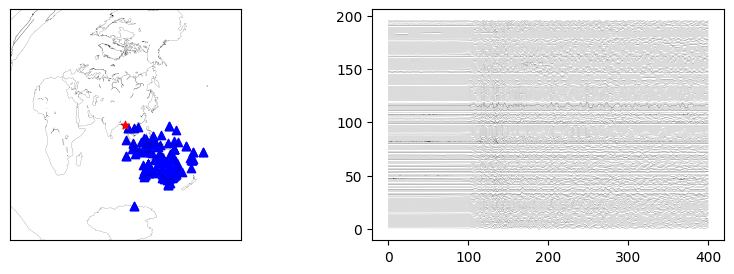

In [352]:
import bp_lib as bp_lib
bp_lib.data_plot(stream_work,event_lat,event_long,'./','test')

In [353]:
from mpl_toolkits.basemap import Basemap
def array_selection_plot(stream,event_lat,event_long,az_min,az_max,dist_min=0,dist_max=90,bp_l=0.1,
                        bp_h=2.0,max_lag=1,time_before=5,time_after=100,corr_thres=0.7,
                         t_plot_start=-20,t_plot_end=100,SNR=2.0):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(5,3))
    #map =  Basemap(projection='cyl', lon_0=event_long,lat_0=event_lat,
    #        resolution='c',ax=ax[0])
    width = 28e6
    #map = Basemap(width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c',ax=ax[1])
    map = Basemap(ax=ax[0],width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c')
    stream_sorted=bp_lib.check_distance(stream,dist_min,dist_max)
    stream_sorted=bp_lib.check_azimuth(stream_sorted,az_min,az_max)
    stream_sorted = bp_lib.snr_check(stream_sorted,SNR,snr_window,time_before)
    #strea_out=stream_sorted.copy()
    Ref_trace_ind =bp_lib.get_ref_station(stream_sorted)
    ref_trace=stream_sorted[Ref_trace_ind]
    stream_sorted=bp_lib.crosscorr_stream_xcorr(stream_sorted,ref_trace,
                                        time_before,time_after,max_lag,bp_l,bp_u,corr_thres)
    #stream_sorted=bp_lib.crosscorr_stream_xcorr_no_filter(stream_sorted,
    #                                                    ref_trace,time_before,time_after,max_lag,threshold_correlation)
    count=0
    for tr_ in stream_sorted:
        count=count+1
        tr=tr_.copy()
        tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
        tr.detrend(type='demean')
        if tr.stats.station == ref_trace.stats.station:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            #tr.normalize()
            #cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp = tr.trim(tr.stats['P_arrival']-t_plot_start+tr.stats['Corr_shift'],
                          tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=temp.data
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut*1,color='red',linewidth=0.8)
            #ax[1].plot(time,tr.data,color='gray')
        else:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            #tr.normalize()
            #cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp = tr.trim(tr.stats['P_arrival']-t_plot_start+tr.stats['Corr_shift'],
                           tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=temp.data
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut*1,color='grey',linewidth=0.5)
            #ax[1].plot(time,tr.data,color='gray')
    map.scatter(event_long,event_lat,latlon=True,facecolor='red',marker='*')
    map.drawcoastlines(linewidth=0.1)
    x, y = map(event_long, event_lat)
    print('Total traces:',len(stream_sorted))
    #focmecs = Focal_mech
    #ax = plt.gca()
    #b = beach(focmecs, xy=(x, y), width=10, linewidth=1, alpha=0.85)
    #b.set_zorder(10000000)
    #ax.add_collection(b)
    ## plot traces
    plt.show()
    #fig.savefig(outdir+'/'+outname)
    return stream_sorted

In [354]:
def crosscorr_stream_xcorr_no_filter(stream,ref_trace,time_start,time_before,time_after,max_lag,corr_thresh):
    '''
    This function cross-correlates traces around P arrival in an obspy stream with a reference trace.
    It also removes traces that have correlation coefficient less an input threshold
    Note: traces are not filtered before cross-correlation

    Input:
    stream : obspy stream
    ref_trace : reference trace in the stream
    time_before : time before P arrival i.e., corr window
    time_after : time after P arrival,i.e., corr window
    max_lag : maximum lag for cross-correlation 
    corr_thresh : correlation value below which traces are removed.

    '''
    for tr in stream:
        try:
            #shift, value = xcorr_pick_correction(ref_trace.stats.P_arrival, ref_trace,tr.stats.P_arrival, tr,
            #    t_before=time_before, t_after=time_after, cc_maxlag=max_lag)#,filter="bandpass",filter_options={'freqmin': bp_l, 'freqmax': bp_u})
            shift, value = xcorr_pick_correction(ref_trace.stats.starttime+time_start, ref_trace,tr.stats.starttime+time_start, tr,
                t_before=time_before, t_after=time_after, cc_maxlag=max_lag)#,filter="bandpass",filter_options={'freqmin': bp_l, 'freqmax': bp_u})


            if (abs(value) >= corr_thresh):
                tr.stats['Corr_coeff'] = value
                tr.stats['Corr_shift']  = shift
                tr.stats['Corr_sign']  = 1.0
            else:
                stream.remove(tr)
        except:
            print('Could not cross-correlate! Hence remove this waveform.')
            stream.remove(tr)
    return stream

In [355]:
def stream_info(stream_in):
    '''
    retunrs stream info:sta,sta_lat,sta_long,dist,azimuth
    '''
    sta = []
    sta_lat = []
    sta_long = []
    dist = []
    azimuth = []
    #backazimuth = []
    for tr in stream_in:
        sta.append(tr.stats.station)
        sta_long.append(tr.stats.station_longitude)
        sta_lat.append(tr.stats.station_latitude)
        dist.append(tr.stats.Dist)
        azimuth.append(tr.stats.Azimuth)
        #backazimuth.append(tr.stats.Backazimuth)
    #to_save = np.column_stack((to_save,backazimuth))
    #np.save('array_bp_info',to_save,allow_pickle=True)
    return sta,sta_lat,sta_long,dist,azimuth
def get_ref_stream_stack(stream_in,event_depth,origin_time):
    '''
    Retunrs stack of the stream as a trace to be used as reference.
    '''
    sta,sta_lat,sta_long,sta_dist,sta_azimuth=stream_info(stream_in)
    temp=stream_in.copy()
    stack_tr=temp.stack()[0]
    stack_tr.stats['Dist']              = np.mean(sta_dist)
    stack_tr.stats['Azimuth']           = np.mean(sta_azimuth)
    stack_tr.stats['station_latitude']  = np.mean(sta_lat)
    stack_tr.stats['station_longitude'] = np.mean(sta_long)
    stack_tr.stats['origin_time']       = origin_time
    arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=stack_tr.stats.Dist,
                                                          phase_list=["P"])
    arr                          = arrivals[0]
    t_travel                     = arr.time;
    stack_tr.stats['P_arrival']         = origin_time + t_travel 
    stack_tr.stats['channel']=stream_in[-1].stats['channel']
    stack_tr.stats['sampling_rate']=stream_in[-1].stats['sampling_rate']
    stack_tr.stats['starttime']=stream_in[-1].stats['starttime']
    ref_trace=stack_tr
    return ref_trace


In [356]:
from mpl_toolkits.basemap import Basemap
def array_selection_plot_(stream,event_lat,event_long,az_min,az_max,dist_min=0,dist_max=90,bp_l=0.1,
                        bp_h=2.0,max_lag=1,start_time=100,time_before=5,time_after=100,corr_thres=0.7,
                         t_plot_start=-20,t_plot_end=100,SNR=2.0):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(5,3))
    #map =  Basemap(projection='cyl', lon_0=event_long,lat_0=event_lat,
    #        resolution='c',ax=ax[0])
    width = 28e6
    #map = Basemap(width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c',ax=ax[1])
    map = Basemap(ax=ax[0],width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c')
    stream_sorted=bp_lib.check_distance(stream,dist_min,dist_max)
    stream_sorted=bp_lib.check_azimuth(stream_sorted,az_min,az_max)
    stream_sorted = bp_lib.snr_check(stream_sorted,SNR,snr_window,time_before)
    sta,sta_lat,sta_long,sta_dist,sta_azimuth=stream_info(stream_sorted)
    ref_trace=get_ref_stream_stack(stream_sorted,event_depth,origin_time)
    #strea_out=stream_sorted.copy()
    #Ref_trace_ind =bp_lib.get_ref_station(stream_sorted)
    #ref_trace=stream_sorted[Ref_trace_ind]
    #stream_sorted=bp_lib.crosscorr_stream_xcorr(stream_sorted,ref_trace,
    #                                    time_before,time_after,max_lag,bp_l,bp_u,corr_thres)
    
    stream_sorted=crosscorr_stream_xcorr_no_filter(stream_sorted,
                                                        ref_trace,start_time,time_before,time_after,max_lag,threshold_correlation)
    

    #stream_sorted=bp_lib.crosscorr_stream_xcorr(stream_sorted,
    #                                                    ref_trace,time_before,time_after,max_lag,bp_l,bp_h,threshold_correlation)
    count=0
    stream_sorted_=stream_sorted.copy()
    for tr in stream_sorted_:
        count=count+1
        #tr.filter('bandpass',freqmin=bp_l,freqmax=bp_h)
        map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
        time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
        temp = tr.trim(tr.stats['P_arrival']-t_plot_start+tr.stats['Corr_shift'],
                          tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
        cut=temp.data
        cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
        cut=cut/np.max(cut) #+ count
        cut=cut +count
        time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
        ax[1].plot(time,cut*1,color='black',linewidth=0.8)
        #ax[1].plot(time,tr.data,color='gray')
    
    count=count+1
    tr=ref_trace
    #tr.filter('bandpass',freqmin=bp_l,freqmax=bp_h)
    map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='red',marker='^')
    time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
    temp = tr.trim(tr.stats['P_arrival']-t_plot_start,
                          tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
    cut=temp.data
    #cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
    cut=cut/np.max(cut) #+ count
    cut=cut +count
    time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
    ax[1].plot(time,cut*1,color='red',linewidth=0.8)
    map.scatter(event_long,event_lat,latlon=True,facecolor='red',marker='*')
    map.drawcoastlines(linewidth=0.1)
    x, y = map(event_long, event_lat)
    print('Total traces:',len(stream_sorted))
    #focmecs = Focal_mech
    #ax = plt.gca()
    #b = beach(focmecs, xy=(x, y), width=10, linewidth=1, alpha=0.85)
    #b.set_zorder(10000000)
    #ax.add_collection(b)
    ## plot traces
    plt.show()
    return stream_sorted
    #fig.savefig(outdir+'/'+outname)

In [366]:
stream_test=stream_work.copy()


Total traces: 71


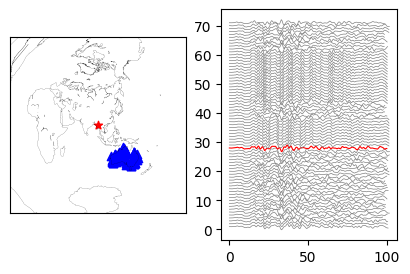

In [348]:
#Australia
az_min=120
az_max=160
dist_min=45 #30
dist_max=80
stream_out=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.05,bp_h=2,max_lag=10,time_before=10,time_after=20,
                     corr_thres=0.2,t_plot_start=0,
                     t_plot_end=100,SNR=4)
#stream_out=array_selection_plot_(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
#                    bp_l=0.2,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
#                     corr_thres=0.1,t_plot_start=10,
#                     t_plot_end=60,SNR=2)

/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/signal/cross_correlation.py:479: UserWarning: Trace ids do not match: ...BHZ != 2O.BTL01.00.BHZ
  warnings.warn(msg)
/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/signal/cross_correlation.py:528: UserWarning: Maximum of cross correlation lower than 0.8: 0.532981327970084
  warnings.warn(msg)
/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/signal/cross_correlation.py:479: UserWarning: Trace ids do not match: ...BHZ != 2O.BTL02.00.BHZ
  warnings.warn(msg)
/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/signal/cross_correlation.py:528: UserWarning: Maximum of cross correlation lower than 0.8: 0.6666170292273182
  warnings.warn(msg)
/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/signal/cross_correlation.py:479: UserWarning: Trace ids do not match: ...BHZ != 2O.BTL03.00.BHZ
  warnings.warn(msg)
/home/aj

Total traces: 45


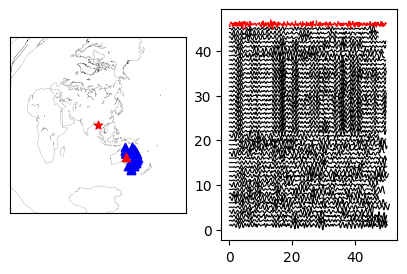

In [368]:
stream_test=stream_work.copy()
az_min=120
az_max=160
dist_min=45 #30
dist_max=80
bp_l=0.8
bp_h=2.5
stream_test= bp_lib.detrend_stream(stream_test,type='demean')
for tr in stream_test:
        tr.filter('bandpass',freqmin=bp_l,freqmax=bp_h)
stream_out=array_selection_plot_(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=1.5,max_lag=10,start_time=Start_P_cut_time,time_before=10,time_after=10,
                     corr_thres=0.4,t_plot_start=0,
                     t_plot_end=50,SNR=3)

In [267]:
stream_out

71 Trace(s) in Stream:

2O.BTL03.00.BHZ | 2025-03-28T06:28:32.600000Z - 2025-03-28T06:35:12.600000Z | 20.0 Hz, 8001 samples
...
(69 other traces)
...
G.CAN.00.BHZ | 2025-03-28T06:31:02.650000Z - 2025-03-28T06:37:42.650000Z | 20.0 Hz, 8001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

71


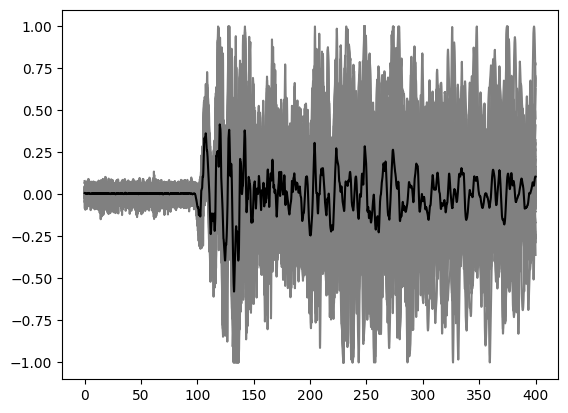

In [268]:
temp=stream_out.copy()
stack_tr=temp.stack()[0]
time = np.arange(0, len(stack_tr.data)/ stack_tr.stats.sampling_rate, stack_tr.stats.delta)

#time=np.arange(0,len(stack_tr.data)*stack_tr.stats['sampling_rate'])
#stack_tr.detrend(type='demean')
#stack_tr.detrend(type='demean')
#stack_tr.normalize()
#stack_tr.detrend(type='demean')

#stack_tr.removemean()

print(len(stream_out))
for tr in stream_out:
#    tr.detrend(type='demean')
#    tr.normalize()
#    tr.detrend(type='demean')
    #time = np.arange(0, len(tr.data)/ tr.stats.sampling_rate, tr.stats.delta)
    plt.plot(time,tr.data,color='grey')
plt.plot(time,stack_tr.data,color='black')


In [269]:
sta,sta_lat,sta_long,sta_dist,sta_azimuth=stream_info(stream_out)
stack_tr.stats['Dist']              = np.mean(sta_dist)
stack_tr.stats['Azimuth']           = np.mean(sta_azimuth)
stack_tr.stats['station_latitude']  = np.mean(sta_lat)
stack_tr.stats['station_longitude'] = np.mean(sta_long)
stack_tr.stats['origin_time']       = origin_time
arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=stack_tr.stats.Dist,
                                                          phase_list=["P"])
arr                          = arrivals[0]
t_travel                     = arr.time;
stack_tr.stats['P_arrival']         = origin_time + t_travel 
#stack_trnetwork: DK
#      station: COP
#     location: 00
stack_tr.stats['sampling_rate']=stream_out[0].stats['sampling_rate']
stack_tr.stats['starttime']=stream_out[0].stats['starttime'] #stack_tr.stats['P_arrival']-stack_start

'''
stack_tr.stats['network']='DK'
stack_tr.stats['location']='00'
stack_tr.stats['station']='EU'
stack_tr.stats['channel']='BHZ'
'''    
#stack_tr.stats['endtime']='2025-03-28T06:36:55.675000Z'
sta_sps.append(stack_tr.stats.sampling_rate)


In [270]:
ref_trace.stats


          network: 
          station: 
         location: 
          channel: BHZ
        starttime: 2025-03-28T06:30:15.675000Z
          endtime: 2025-03-28T06:36:55.675000Z
    sampling_rate: 20.0
            delta: 0.05
             npts: 8001
            calib: 1.0
          Azimuth: -45.937911398384195
        Corr_sign: 1.0
             Dist: 68.44861498390135
        P_arrival: 2025-03-28T06:31:56.157728Z
          _format: MSEED
      origin_time: 2025-03-28T06:20:54.000000Z
            stack: AttribDict({'group': 'all', 'count': 126, 'type': 'linear'})
 station_latitude: 47.2496056747619
station_longitude: 14.449315825555555

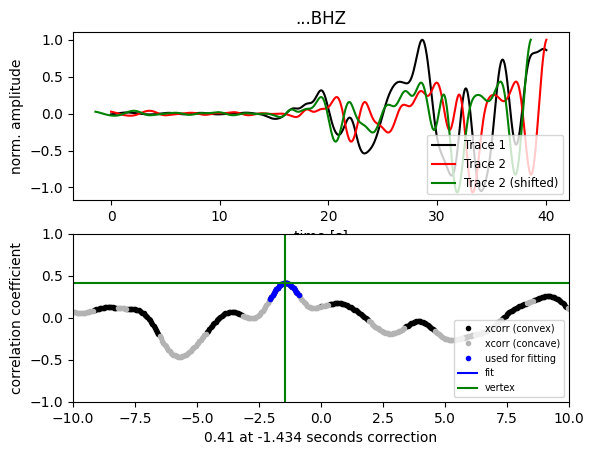

1.4337082466343578 0.40960370664232676


In [300]:
bp_l=0.1
bp_u=0.5
ref_trace=stack_tr.copy()
tr=stream_out[-1].copy()
time_before=10
time_after=20
max_lag=10
ref_trace.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
shift, value = xcorr_pick_correction(ref_trace.stats.starttime+Start_P_cut_time, ref_trace,tr.stats.starttime+Start_P_cut_time, tr,
                t_before=time_before, t_after=time_after, cc_maxlag=max_lag,plot=True)#,filter="bandpass",filter_options={'freqmin': bp_l, 'freqmax': bp_u})
print(shift,value)

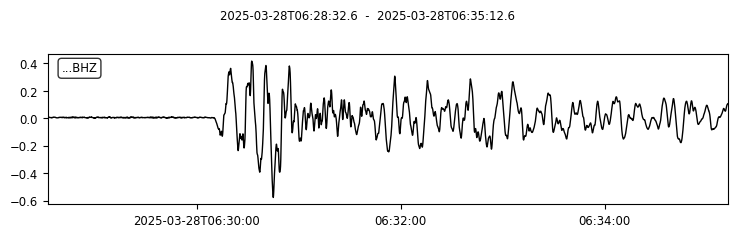

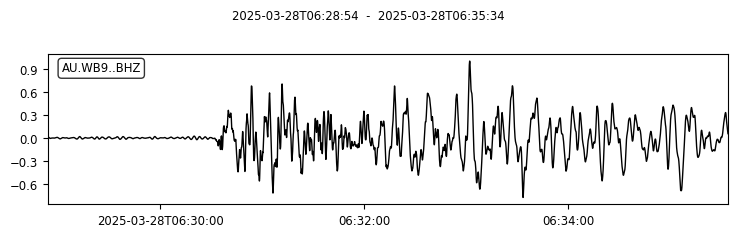

In [278]:
ref_trace.plot();
tr.plot();

Total traces: 126


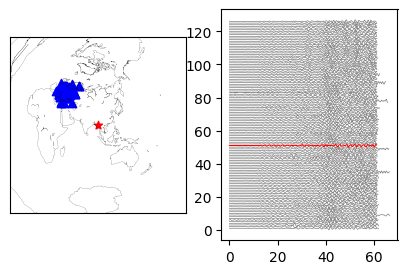

In [7]:
#EU
az_min=-180 #118
az_max=-25 #160
dist_min=45 #45
dist_max=80 #80
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thres=0.6,t_plot_start=1,
                     t_plot_end=60,SNR=2)

Total traces: 86


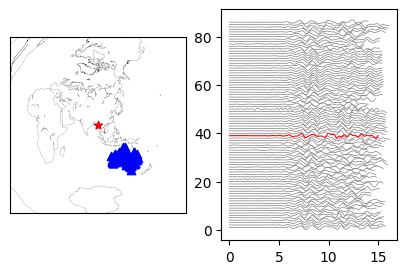

In [8]:
#Australia
az_min=120
az_max=160
dist_min=45 #30
dist_max=80
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thres=0.6,t_plot_start=5,
                     t_plot_end=10,SNR=2)

Total traces: 110


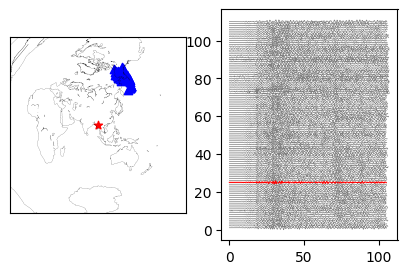

In [211]:
#USA
az_min=10
az_max=80
dist_min=60 #30
dist_max=90
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thres=0.6,t_plot_start=5,
                     t_plot_end=100,SNR=2)


D:\Work\tools\earthquake_bp_obspy\bp_lib.py:405: RuntimeWarning: invalid value encountered in scalar divide
  x_centroid = x_sum / n
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:406: RuntimeWarning: invalid value encountered in scalar divide
  y_centroid = y_sum / n


ValueError: attempt to get argmin of an empty sequence

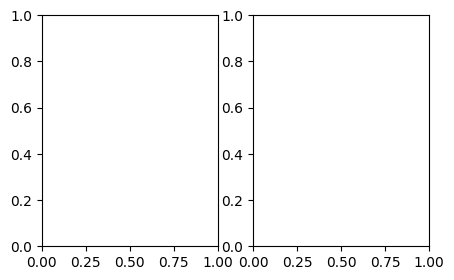

In [128]:
az_min=40
az_max=90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

D:\Work\tools\earthquake_bp_obspy\bp_lib.py:733: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the start.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:733: UserWarning: Artifacts from signal processing possible. Trace 1 should have more additional data at the start.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:777: UserWarning: Fitting at maximum lag. Maximum lag time should be increased.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:787: UserWarning: Less than 5 samples selected for fit to cross correlation: 4
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:787: UserWarning: Less than 5 samples selected for fit to cross correlation: 3
  warnings.warn(msg)


Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.


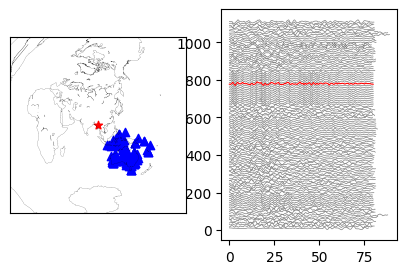

In [129]:
az_min=90
az_max=160
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

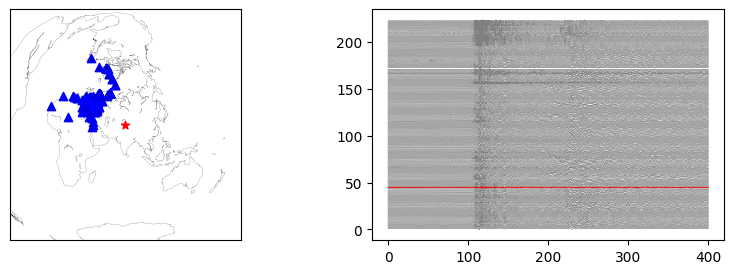

In [29]:
az_min=-120
az_max=0
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

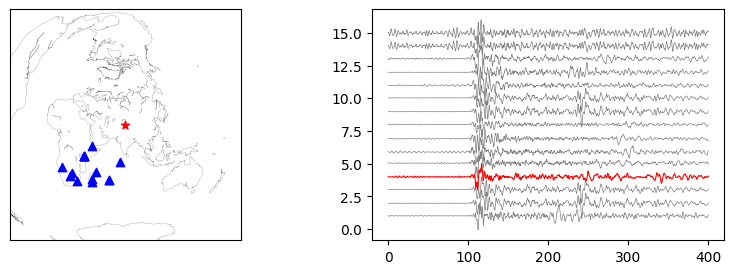

In [30]:
az_min=-179
az_max=-120
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

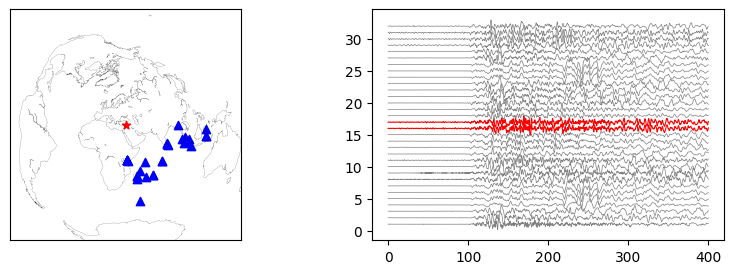

In [44]:
az_min=90
az_max=180
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

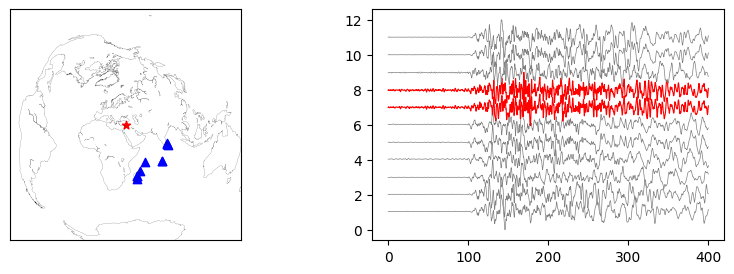

In [41]:
az_min=100
az_max=170
dist_min=30
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

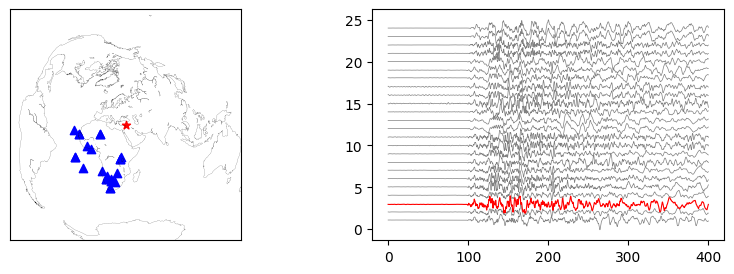

In [42]:
az_min=-179
az_max=-90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

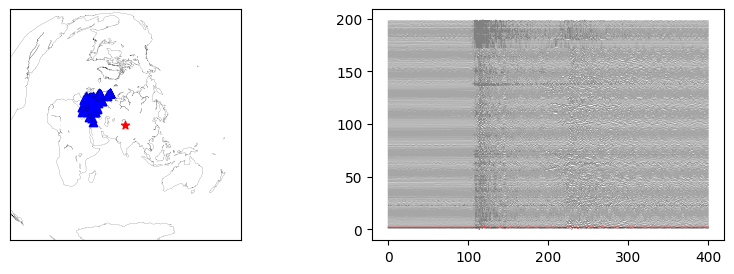

In [31]:
az_min=-90
az_max=-20
dist_min=35
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

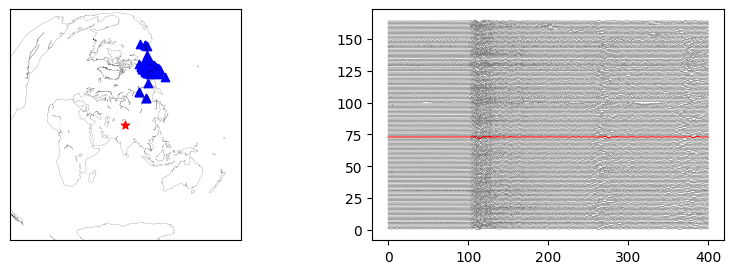

In [148]:
az_min=-10
az_max=40
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

In [23]:
az=[]
baz=[]
for t in stream_work:
    az.append(t.stats.Azimuth)
    baz.append(t.stats.Backazimuth)

In [6]:
stream_stack=stream_for_bp.copy()
st=stream_stack.stack('linear')

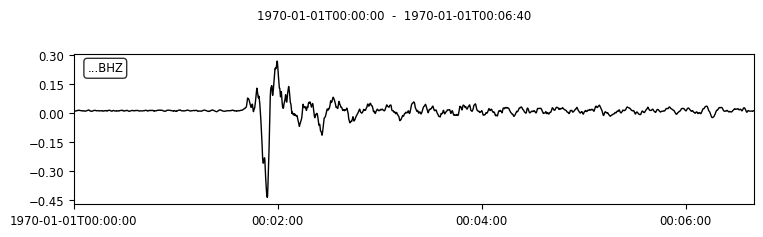

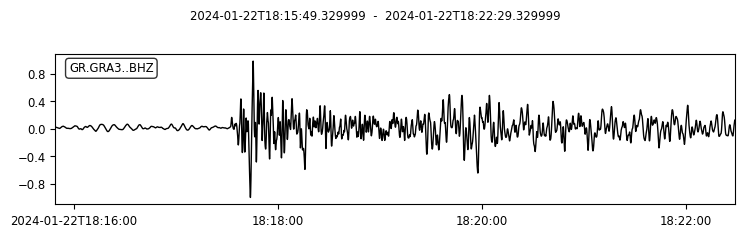

In [7]:
st.plot();
t=stream_for_bp[10]
t.plot();

          network: GR
          station: GRA3
         location: 
          channel: BHZ
        starttime: 2024-01-22T18:15:49.329999Z
          endtime: 2024-01-22T18:22:29.329999Z
    sampling_rate: 10.0
            delta: 0.1
             npts: 4001
            calib: 1.0
          Azimuth: -55.50818762435577
             Dist: 46.32020828683203
        P_arrival: 2024-01-22T18:17:29.372930Z
          _format: MSEED
            mseed: AttribDict({'dataquality': 'D', 'number_of_records': 58, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 44402688})
      origin_time: 2024-01-22T18:09:04.000000Z
       processing: ["ObsPy 1.4.0: resample(no_filter=True::sampling_rate=10.0::strict_length=False::window='hann')", 'ObsPy 1.4.0: trim(endtime=UTCDateTime(2024, 1, 22, 18, 22, 29, 372930)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 1, 22, 18, 15, 49, 372930))', 'ObsPy 1.4.0: normalize(norm=None)']
 station_latitude: 49.761076
stati

(-90.0, 90.0)

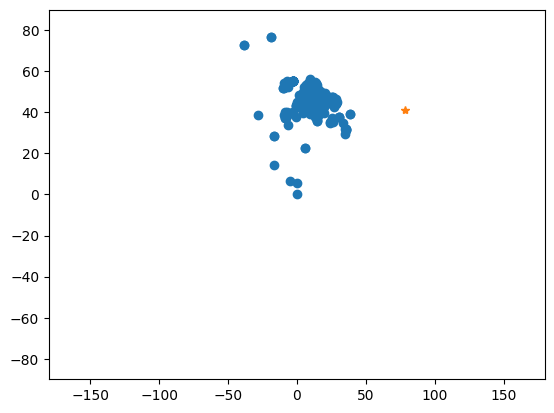

In [24]:
baz_min=45
baz_max=80
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Backazimuth >= baz_min and t.stats.Backazimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

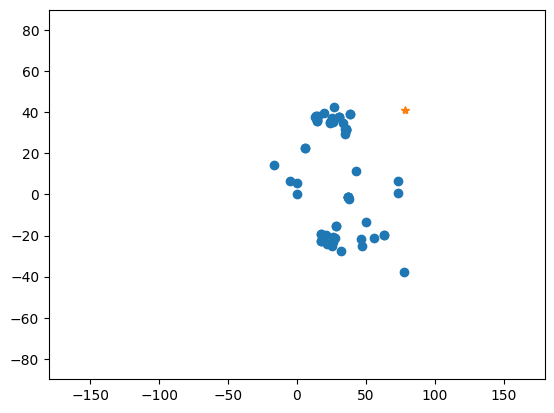

In [16]:
baz_min=-180
baz_max=-70
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

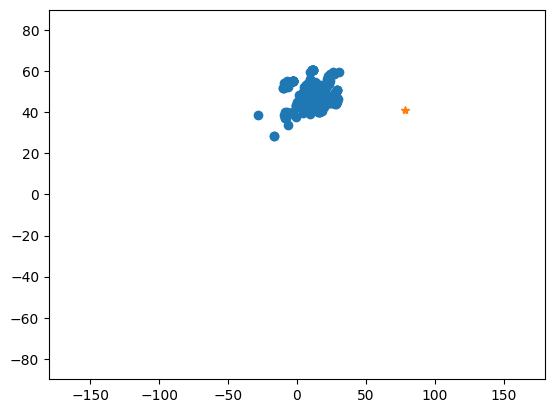

In [17]:
baz_min=-70
baz_max=-40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

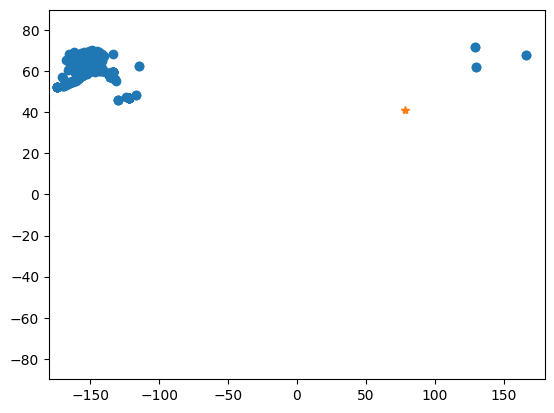

In [20]:
baz_min=-10
baz_max=40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)